# ProteinMCP — Fitness Modeling Workflow

Build and compare protein fitness prediction models using multiple backbone architectures:

| Model | Description |
|-------|-------------|
| **EV+OneHot** | Evolutionary couplings + one-hot encoding (PLMC) |
| **ESM2-650M / ESM2-3B** | Meta's protein language models |
| **ProtT5-XL / ProtAlbert** | ProtTrans transformer embeddings |

Each model is trained with SVR, XGBoost, and KNN heads, then compared via 5-fold cross-validated Spearman correlation.

**Prerequisites:** Docker, Claude Code CLI, ProteinMCP installed locally.

**Links:** [GitHub](https://github.com/charlesxu90/ProteinMCP) · [ESM](https://github.com/facebookresearch/esm) · [ProtTrans](https://github.com/agemagician/ProtTrans) · [PLMC](https://github.com/debbiemarkslab/plmc)

---

## Job configs

In [1]:
# ── User Configuration ──
PROTEIN_NAME = "TEVp_S219V"
use_example_data = True

# Optional: set API key here or in .env. If unset, Claude CLI uses your logged-in account.
ANTHROPIC_API_KEY = ""
CLAUDE_MODEL = "claude-sonnet-4-6"

## Import utility and define functions

In [2]:
import os
import subprocess
import json
import select

# ---------- Streaming command runner ----------
def run_cmd(cmd, cwd=None):
    """Run a shell command and stream stdout/stderr line-by-line in real time."""
    proc = subprocess.Popen(
        cmd, shell=True, cwd=cwd,
        stdout=subprocess.PIPE, stderr=subprocess.STDOUT,
        bufsize=1, text=True,
    )
    for line in proc.stdout:
        print(line, end="", flush=True)
    proc.wait()
    if proc.returncode != 0:
        print(f"\n⚠️  Command exited with code {proc.returncode}")
    return proc.returncode

# ---------- Claude streaming helper ----------
def _display_claude_line(line):
    """Parse a single stream-json line from Claude CLI and print progress."""
    if not line.strip():
        return
    try:
        data = json.loads(line)
        msg_type = data.get('type', '')
        subtype = data.get('subtype', '')

        if msg_type == 'system':
            if subtype == 'init':
                session_id = data.get('session_id', '')[:8]
                print(f"  🤖 Session started: {session_id}...", flush=True)
            elif subtype != 'transcript':
                print(f"  ⚙️  System: {subtype}", flush=True)

        elif msg_type == 'assistant':
            message = data.get('message', {})
            for block in message.get('content', []):
                block_type = block.get('type', '')
                if block_type == 'thinking':
                    text = block.get('thinking', '')[:100]
                    print(f"  💭 Thinking: {text}...", flush=True)
                elif block_type == 'text':
                    lines = block.get('text', '').strip().split('\n')
                    for tl in lines[:5]:
                        if tl.strip():
                            print(f"  {tl}", flush=True)
                    if len(lines) > 5:
                        print(f"  ... ({len(lines) - 5} more lines)", flush=True)
                elif block_type == 'tool_use':
                    tool_name = block.get('name', 'unknown')
                    tool_input = block.get('input', {})
                    if tool_name == 'Bash':
                        print(f"  🔧 Bash: {tool_input.get('command', '')[:80]}", flush=True)
                    elif tool_name in ('Read', 'Write', 'Edit'):
                        print(f"  📖 {tool_name}: {tool_input.get('file_path', '')}", flush=True)
                    elif tool_name.startswith('mcp__'):
                        print(f"  🔌 MCP: {tool_name}", flush=True)
                    else:
                        print(f"  🔧 {tool_name}", flush=True)

        elif msg_type == 'user':
            for block in data.get('message', {}).get('content', []):
                if block.get('type') == 'tool_result':
                    if block.get('is_error', False):
                        err = block.get('content', '')
                        err = err[:100] if isinstance(err, str) else str(err)[:100]
                        print(f"  ❌ Error: {err}", flush=True)
                    else:
                        content = block.get('content', '')
                        if isinstance(content, str) and content.strip():
                            first = content.strip().split('\n')[0][:80]
                            if first:
                                print(f"  ✅ Result: {first}", flush=True)
                        else:
                            print(f"  ✅ Done", flush=True)

        elif msg_type == 'result':
            if subtype == 'success':
                print(f"  ✅ Completed successfully", flush=True)
            elif subtype == 'error':
                print(f"  ❌ Error: {data.get('error', 'Unknown')}", flush=True)

    except json.JSONDecodeError:
        if line.strip():
            print(f"  {line}", flush=True)


def run_claude(prompt, allowed_tools=None, cwd=None, model=None):
    """Run Claude CLI with real-time streaming output.

    Args:
        prompt: The prompt text to send to Claude (passed via stdin).
        allowed_tools: Comma-separated tool names, e.g. "Bash,Read,Write".
        cwd: Working directory for the claude process.
        model: Model name override. Defaults to CLAUDE_MODEL global.

    Returns:
        Process return code (0 = success).
    """
    _model = model or CLAUDE_MODEL
    cmd = [
        "claude",
        "--model", _model,
        "-p", "-",
        "--output-format", "stream-json",
        "--verbose",
        "--dangerously-skip-permissions",
    ]
    if allowed_tools:
        cmd += ["--allowedTools", allowed_tools]

    print(f"  🤖 Claude model: {_model}")
    print(f"  📋 Tools: {allowed_tools or 'all'}")
    print(f"  " + "-" * 58)

    proc = subprocess.Popen(
        cmd, cwd=cwd,
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True, bufsize=1,
    )
    proc.stdin.write(prompt)
    proc.stdin.close()

    while True:
        if proc.poll() is not None:
            # Drain remaining output
            for line in (proc.stdout.read() or '').split('\n'):
                _display_claude_line(line)
            for line in (proc.stderr.read() or '').split('\n'):
                if line.strip():
                    print(f"  ⚙️  {line}", flush=True)
            break

        try:
            readable, _, _ = select.select([proc.stdout, proc.stderr], [], [], 0.1)
        except (ValueError, OSError):
            break

        for stream in readable:
            line = stream.readline()
            if line:
                if stream == proc.stdout:
                    _display_claude_line(line.rstrip('\n'))
                else:
                    if line.strip():
                        print(f"  ⚙️  {line.rstrip()}", flush=True)

    rc = proc.wait()
    print(f"  " + "-" * 58)
    if rc != 0:
        print(f"  ⚠️  Claude exited with code {rc}")
    return rc

## Setup and verify the environment

In [3]:
# ---------- Paths ----------
# Auto-detect REPO_DIR: walk up from notebook location to find project root
_nb_dir = os.path.abspath("")
if os.path.basename(_nb_dir) == "notebooks":
    REPO_DIR = os.path.dirname(_nb_dir)
else:
    REPO_DIR = _nb_dir

# ---------- Load API key from .env if not set ----------
if not ANTHROPIC_API_KEY:
    _env_file = os.path.join(REPO_DIR, ".env")
    if os.path.exists(_env_file):
        with open(_env_file) as f:
            for line in f:
                line = line.strip()
                if line.startswith("ANTHROPIC_API_KEY="):
                    ANTHROPIC_API_KEY = line.split("=", 1)[1].strip().strip("\"'")
                    break
        if ANTHROPIC_API_KEY:
            print(f"Loaded ANTHROPIC_API_KEY from {_env_file}")

if ANTHROPIC_API_KEY:
    os.environ["ANTHROPIC_API_KEY"] = ANTHROPIC_API_KEY
    print(f"Using API key (ends with ...{ANTHROPIC_API_KEY[-4:]})")
else:
    print("No API key set — Claude CLI will use your logged-in account.")

# ---------- Data paths ----------
DATA_DIR    = os.path.join(REPO_DIR, "data", PROTEIN_NAME)
RESULTS_DIR = os.path.join(REPO_DIR, "results", PROTEIN_NAME)

WT_FASTA = os.path.join(DATA_DIR, "wt.fasta")
DATA_CSV = os.path.join(DATA_DIR, "data.csv")

os.makedirs(DATA_DIR, exist_ok=True)

if use_example_data:
    print(f"Will use bundled example data for {PROTEIN_NAME}")
else:
    print(f"Please place your wt.fasta and data.csv files in:\n  {DATA_DIR}")
    input("Press Enter once the files are in place...")
    assert os.path.exists(WT_FASTA), f"Missing {WT_FASTA} — please provide wt.fasta"
    assert os.path.exists(DATA_CSV),  f"Missing {DATA_CSV} — please provide data.csv"

print(f"\nCLAUDE_MODEL : {CLAUDE_MODEL}")
print(f"PROTEIN_NAME : {PROTEIN_NAME}")
print(f"REPO_DIR     : {REPO_DIR}")
print(f"DATA_DIR     : {DATA_DIR}")
print(f"RESULTS_DIR  : {RESULTS_DIR}")
print(f"WT_FASTA     : {WT_FASTA}")
print(f"DATA_CSV     : {DATA_CSV}")

No API key set — Claude CLI will use your logged-in account.
Will use bundled example data for TEVp_S219V

CLAUDE_MODEL : claude-sonnet-4-6
PROTEIN_NAME : TEVp_S219V
REPO_DIR     : /home/xux/Desktop/AgentMCP/ProteinMCP
DATA_DIR     : /home/xux/Desktop/AgentMCP/ProteinMCP/data/TEVp_S219V
RESULTS_DIR  : /home/xux/Desktop/AgentMCP/ProteinMCP/results/TEVp_S219V
WT_FASTA     : /home/xux/Desktop/AgentMCP/ProteinMCP/data/TEVp_S219V/wt.fasta
DATA_CSV     : /home/xux/Desktop/AgentMCP/ProteinMCP/data/TEVp_S219V/data.csv


## Install & Register MCPs

> **Tip — Local Docker builds:** Some Docker MCP images (e.g. `esm_mcp`) are large and may
> time out during `pmcp install`. You can build and register them locally instead:
> ```bash
> cd tool-mcps/esm_mcp && docker build -t esm_mcp:latest . && cd ../..
> claude mcp add esm_mcp -- docker run -i --rm --gpus all --ipc=host -v $PWD:$PWD esm_mcp:latest
> ```
> Replace `esm_mcp` with any other Docker MCP name (`plmc_mcp`, `ev_onehot_mcp`, `prottrans_mcp`) as needed.
> The install cell below will skip MCPs that are already registered.

In [4]:
import os, time
_t0 = time.time()

# Install ProteinMCP if not already present
if run_cmd("which pmcp") != 0:
    run_cmd(f"pip install -e {REPO_DIR}")
    run_cmd(f"pip install -r {REPO_DIR}/requirements.txt")
else:
    print("ProteinMCP already installed.")

# Install Claude Code if not already present
if run_cmd("which claude") != 0:
    run_cmd("npm install -g @anthropic-ai/claude-code")
else:
    print("Claude Code already installed.")

# Verify Docker is available (required for Docker MCPs)
if run_cmd("docker --version") != 0:
    print("WARNING: Docker not found. Docker MCPs will not work.")
else:
    print("Docker found.")

print("ProteinMCP & Claude Code ready.")
print(f"\nElapsed: {time.time() - _t0:.1f}s")

/home/xux/miniforge3/envs/protein-mcp/bin/pmcp
ProteinMCP already installed.
/home/xux/.local/bin/claude
Claude Code already installed.
Docker version 29.2.1, build a5c7197
Docker found.
ProteinMCP & Claude Code ready.

Elapsed: 0.0s


In [5]:
import time
import concurrent.futures
_t0 = time.time()

# Required MCPs for fitness modeling workflow
REQUIRED_MCPS = ["msa_mcp", "plmc_mcp", "ev_onehot_mcp", "esm_mcp", "prottrans_mcp"]

# Check which MCPs are already registered
_registered = subprocess.run(["claude", "mcp", "list"], capture_output=True, text=True).stdout
_to_install = [m for m in REQUIRED_MCPS if m not in _registered]

if _to_install:
    print(f"Installing {len(_to_install)} MCPs: {_to_install}")
    _skipped = [m for m in REQUIRED_MCPS if m in _registered]
    if _skipped:
        print(f"Skipping already registered: {_skipped}")

    def _install_mcp(mcp_name):
        """Install a single MCP, capturing output for parallel execution."""
        result = subprocess.run(
            ["pmcp", "install", mcp_name],
            capture_output=True, text=True, cwd=REPO_DIR, timeout=1800
        )
        return mcp_name, result.returncode, result.stdout, result.stderr

    # Install (pull Docker images) and register MCPs in parallel
    with concurrent.futures.ThreadPoolExecutor(max_workers=len(_to_install)) as executor:
        futures = {executor.submit(_install_mcp, name): name for name in _to_install}
        for future in concurrent.futures.as_completed(futures):
            name, rc, stdout, stderr = future.result()
            status = "OK" if rc == 0 else "FAILED"
            print(f"\n{'='*50}")
            print(f"  {name}: {status}")
            # Show last few meaningful lines
            for line in stdout.strip().splitlines()[-5:]:
                if line.strip():
                    print(f"    {line.strip()}")
            if rc != 0 and stderr:
                print(f"    stderr: {stderr.strip()[:200]}")
else:
    print("All MCPs already registered. Skipping installation.")

# Verify MCP status
print(f"\n{'='*50}")
run_cmd("claude mcp list", cwd=REPO_DIR)
print(f"\nElapsed: {time.time() - _t0:.1f}s")

All MCPs already registered. Skipping installation.

Checking MCP server health...

msa_mcp: python /mnt/data/done_projects/2026/BioMolMCP/ProteinMCP/tool-mcps/msa_mcp/src/server.py - ✓ Connected
plmc_mcp: docker run -i --rm --user 129052:1129052 --gpus all --ipc=host -v /home/xux/Desktop/AgentMCP/ProteinMCP:/home/xux/Desktop/AgentMCP/ProteinMCP plmc_mcp:latest - ✓ Connected
ev_onehot_mcp: docker run -i --rm --user 129052:1129052 --gpus all --ipc=host -v /home/xux/Desktop/AgentMCP/ProteinMCP:/home/xux/Desktop/AgentMCP/ProteinMCP ev_onehot_mcp:latest - ✓ Connected
prottrans_mcp: docker run -i --rm --user 129052:1129052 --gpus all --ipc=host -e HOME=/home/xux -v /home/xux/Desktop/AgentMCP/ProteinMCP:/home/xux/Desktop/AgentMCP/ProteinMCP -v /home/xux/.cache:/home/xux/.cache prottrans_mcp:latest - ✓ Connected
bindcraft_mcp: docker run -i --rm --user 129052:1129052 --gpus all --ipc=host -v /home/xux/Desktop/AgentMCP/ProteinMCP:/home/xux/Desktop/AgentMCP/ProteinMCP bindcraft_mcp:latest - ✓ C

## Step 0 — Setup Results Directory

In [6]:
import os, shutil

EXAMPLE_DIR = os.path.join(REPO_DIR, "examples", "case1_fitness_modeling")

os.makedirs(RESULTS_DIR, exist_ok=True)

if use_example_data:
    # Copy bundled example data into DATA_DIR
    for fname in ["wt.fasta", "data.csv"]:
        src = os.path.join(EXAMPLE_DIR, fname)
        dst = os.path.join(DATA_DIR, fname)
        if not os.path.exists(dst):
            shutil.copy2(src, dst)
            print(f"Copied {src} → {dst}")

# Copy input files to RESULTS_DIR (needed by training tools)
for fname in ["wt.fasta", "data.csv"]:
    src = os.path.join(DATA_DIR, fname)
    dst = os.path.join(RESULTS_DIR, fname)
    if not os.path.exists(dst):
        shutil.copy2(src, dst)
        print(f"Copied {src} → {dst}")

# Verify
assert os.path.exists(os.path.join(RESULTS_DIR, "wt.fasta")), "wt.fasta missing in RESULTS_DIR"
assert os.path.exists(os.path.join(RESULTS_DIR, "data.csv")),  "data.csv missing in RESULTS_DIR"
print(f"\nResults directory ready: {RESULTS_DIR}")
print(f"Files: {os.listdir(RESULTS_DIR)}")


Results directory ready: /home/xux/Desktop/AgentMCP/ProteinMCP/results/TEVp_S219V
Files: ['esm2_t36_3B_UR50D', 'data.csv.esm2_t33_650M_UR50D.npy', 'esm2_650M_knn', 'ev_onehot_observed.npy', 'metrics_summary.csv', 'ridge_model.joblib', 'esm2_t33_650M_UR50D', 'esm2_650M_svr', 'TEVp_S219V.a3m', 'esm2_650M_xgboost', 'sequences.fasta', 'plmc', 'data.csv', 'wt.fasta', 'ev_onehot_predictions.npy']


## Step 1 — Generate MSA

In [7]:
import os, time
_t0 = time.time()

prompt = f"""\
Can you obtain the MSA for {PROTEIN_NAME} from {WT_FASTA} using msa mcp \
and save it to {RESULTS_DIR}/{PROTEIN_NAME}.a3m.
Please convert the relative path to absolute path before calling the MCP servers.
"""

run_claude(
    prompt,
    allowed_tools="mcp__msa_mcp__generate_msa,Bash,Read,Write",
    cwd=REPO_DIR,
)

# Verify output
msa_file = f"{RESULTS_DIR}/{PROTEIN_NAME}.a3m"
assert os.path.exists(msa_file), f"MSA file not found: {msa_file}"
print(f"\nMSA generated: {msa_file}")
print(f"Elapsed: {time.time() - _t0:.1f}s")

  🤖 Claude model: claude-sonnet-4-6
  📋 Tools: mcp__msa_mcp__generate_msa,Bash,Read,Write
  ----------------------------------------------------------


  🤖 Session started: 3ebbf297...
  💭 Thinking: Let me read the FASTA file first to get the sequence....
  📖 Read: /home/xux/Desktop/AgentMCP/ProteinMCP/data/TEVp_S219V/wt.fasta
  ✅ Result: 1→>TEVp_S219V
  🔧 Bash: mkdir -p /home/xux/Desktop/AgentMCP/ProteinMCP/results/TEVp_S219V
  ✅ Done
  🔌 MCP: mcp__msa_mcp__generate_msa
  ✅ Result: {"status":"success","ticket_id":"iyy0MMnm2QhYJwooxY4iERYXJRNBSBzDMyy8Fg","output
  MSA generated successfully. Here's a summary:
  - **Output file:** `/home/xux/Desktop/AgentMCP/ProteinMCP/results/TEVp_S219V/TEVp_S219V.a3m`
  - **Sequence length:** 236 amino acids
  - **MSA depth:** 472 sequences
  ... (1 more lines)
  ✅ Completed successfully
  ----------------------------------------------------------

MSA generated: /home/xux/Desktop/AgentMCP/ProteinMCP/results/TEVp_S219V/TEVp_S219V.a3m
Elapsed: 48.9s


## Step 2 — Build PLMC Model

In [8]:
import os, time, subprocess, glob as globmod
_t0 = time.time()

prompt = f"""\
I have created an a3m file in {RESULTS_DIR}/{PROTEIN_NAME}.a3m. \
Can you help build an EV model using plmc mcp and save it to {RESULTS_DIR}/plmc directory. \
The wild-type sequence is {WT_FASTA}.
Please convert the relative path to absolute path before calling the MCP servers.
"""

run_claude(
    prompt,
    allowed_tools="mcp__plmc_mcp__plmc_convert_a3m_to_a2m,mcp__plmc_mcp__plmc_generate_model,Bash,Read,Write",
    cwd=REPO_DIR,
)

# Create symlinks: ev_onehot_mcp expects uniref100.model_params and uniref100.EC
plmc_dir = f"{RESULTS_DIR}/plmc"

# Fix ownership if directory is root-owned (Docker container artifact)
if os.path.isdir(plmc_dir) and not os.access(plmc_dir, os.W_OK):
    uid, gid = os.getuid(), os.getgid()
    subprocess.run(["sudo", "chown", "-R", f"{uid}:{gid}", plmc_dir])

# Find actual output files and create symlinks
for suffix in ["model_params", "EC"]:
    link_path = os.path.join(plmc_dir, f"uniref100.{suffix}")
    if os.path.isfile(link_path):
        continue  # Already exists as a real file
    if os.path.islink(link_path) and os.path.exists(link_path):
        continue  # Valid symlink already exists
    # Remove broken symlink if present
    if os.path.islink(link_path):
        os.unlink(link_path)
    # Find the actual file (e.g. TEVp_S219V.model_params)
    candidates = [f for f in os.listdir(plmc_dir)
                  if f.endswith(f".{suffix}") and f != f"uniref100.{suffix}"]
    if candidates:
        os.symlink(candidates[0], link_path)
        print(f"Symlinked {candidates[0]} -> uniref100.{suffix}")

# Verify outputs
assert os.path.exists(f"{plmc_dir}/uniref100.model_params"), "PLMC model_params symlink missing"
assert os.path.exists(f"{plmc_dir}/uniref100.EC"), "PLMC EC symlink missing"
print(f"\nPLMC model built: {os.listdir(plmc_dir)}")
print(f"Elapsed: {time.time() - _t0:.1f}s")

  🤖 Claude model: claude-sonnet-4-6
  📋 Tools: mcp__plmc_mcp__plmc_convert_a3m_to_a2m,mcp__plmc_mcp__plmc_generate_model,Bash,Read,Write
  ----------------------------------------------------------
  🤖 Session started: cb95d220...
  💭 Thinking: The user wants to build an EV model using plmc MCP. The steps are:
1. Convert A3M to A2M format usin...
  Let me first check the WT fasta to get the sequence ID, then run the pipeline.
  📖 Read: /home/xux/Desktop/AgentMCP/ProteinMCP/data/TEVp_S219V/wt.fasta
  ✅ Result: 1→>TEVp_S219V
  The focus sequence ID is `TEVp_S219V`. Now I'll convert the A3M to A2M first, then generate the plmc model.
  🔌 MCP: mcp__plmc_mcp__plmc_convert_a3m_to_a2m
  ✅ Result: {"message":"Successfully converted A3M to A2M format and cleaned query gaps","re
  A2M conversion done. Now generating the plmc model.
  🔌 MCP: mcp__plmc_mcp__plmc_generate_model
  ✅ Result: {"message":"PLMC model generated successfully for TEVp_S219V","reference":"https
  The EV model is built. Here

## Step 3 — Build EV+OneHot Model

In [9]:
import os, time
_t0 = time.time()

prompt = f"""\
I have created a plmc model in directory {RESULTS_DIR}/plmc. \
Can you help build an EV+OneHot model using ev_onehot_mcp and save it to {RESULTS_DIR}/ directory. \
The wild-type sequence is {RESULTS_DIR}/wt.fasta, and the dataset is {RESULTS_DIR}/data.csv.
Please convert the relative path to absolute path before calling the MCP servers.
"""

run_claude(
    prompt,
    allowed_tools="mcp__ev_onehot_mcp__ev_onehot_train_fitness_predictor,Bash,Read,Write",
    cwd=REPO_DIR,
)

# Verify output
assert os.path.exists(f"{RESULTS_DIR}/metrics_summary.csv"), "EV+OneHot metrics not found"
print(f"\nEV+OneHot model trained. Metrics:")
import pandas as pd
print(pd.read_csv(f"{RESULTS_DIR}/metrics_summary.csv").to_string(index=False))
print(f"\nElapsed: {time.time() - _t0:.1f}s")

  🤖 Claude model: claude-sonnet-4-6
  📋 Tools: mcp__ev_onehot_mcp__ev_onehot_train_fitness_predictor,Bash,Read,Write
  ----------------------------------------------------------
  🤖 Session started: c763b62a...
  💭 Thinking: The user wants to train an EV+Onehot fitness prediction model using the ev_onehot_mcp tool. Let me c...
  Let me check the directory structure first.
  🔧 Bash: ls /home/xux/Desktop/AgentMCP/ProteinMCP/results/TEVp_S219V/ && echo "---" && ls
  ✅ Result: data.csv
  💭 Thinking: The directory structure looks good. The plmc directory has the model parameters. Now I need to call ...
  🔧 Bash: head -3 /home/xux/Desktop/AgentMCP/ProteinMCP/results/TEVp_S219V/data.csv
  ✅ Result: AACombo,AA1,AA2,AA3,AA4,fitness,active,muts,n_mut,mutations,seq,n_muts,log_fitne
  The directory structure looks correct. I'll now train the EV+Onehot model with all absolute paths.
  🔌 MCP: mcp__ev_onehot_mcp__ev_onehot_train_fitness_predictor
  ✅ Result: {"message":"5-fold CV: 0.261 ± 0.084, Fina

## Step 4 — Build ESM Models

In [10]:
import os, time
_t0 = time.time()

# ESM tool names for allowed_tools
_ESM_TOOLS = ",".join([
    "mcp__esm_mcp__esm_extract_embeddings_from_csv",
    "mcp__esm_mcp__esm_train_fitness_model",
    "Bash", "Read", "Write",
])

# --- 4.1: ESM2-650M (extract embeddings + train svr/xgboost/knn) ---
print("="*60)
print("ESM2-650M: extracting embeddings & training models")
print("="*60)

prompt_650m = f"""\
Can you help train ESM models for data in {RESULTS_DIR}/ and save them to \
{RESULTS_DIR}/ESM2-650M_{{head_model}} using the esm_mcp server with svr, xgboost, \
and knn as the head models.
Please convert the relative path to absolute path before calling the MCP servers.
Extract the embeddings first if they are not already created.
"""

run_claude(prompt_650m, allowed_tools=_ESM_TOOLS, cwd=REPO_DIR)

# --- 4.2: ESM2-3B (extract embeddings + train svr/xgboost/knn) ---
print("\n" + "="*60)
print("ESM2-3B: extracting embeddings & training models")
print("="*60)

prompt_3b = f"""\
Can you help train ESM models for data in {RESULTS_DIR}/ and save them to \
{RESULTS_DIR}/ESM2-3B_{{head_model}} using the esm mcp server with svr, xgboost, \
and knn as the head models and esm2_t36_3B_UR50D as the backbone.
Please convert the relative path to absolute path before calling the MCP servers.
Extract the embeddings first if they are not already created.
"""

run_claude(prompt_3b, allowed_tools=_ESM_TOOLS, cwd=REPO_DIR)

# Verify
print("\n" + "="*60)
print("ESM model outputs:")
print("="*60)
for backbone in ["ESM2-650M", "ESM2-3B"]:
    for head in ["svr", "xgboost", "knn"]:
        d = f"{RESULTS_DIR}/{backbone}_{head}"
        if os.path.isdir(d):
            print(f"  ✓ {backbone}_{head}: {os.listdir(d)}")
        else:
            print(f"  ✗ {backbone}_{head}: NOT FOUND")

print(f"\nElapsed: {time.time() - _t0:.1f}s")

ESM2-650M: extracting embeddings & training models
  🤖 Claude model: claude-sonnet-4-6
  📋 Tools: mcp__esm_mcp__esm_extract_embeddings_from_csv,mcp__esm_mcp__esm_train_fitness_model,Bash,Read,Write
  ----------------------------------------------------------
  🤖 Session started: e3fe196b...
  💭 Thinking: Let me check the data directory first to understand what's there....
  🔧 Bash: ls /home/xux/Desktop/AgentMCP/ProteinMCP/results/TEVp_S219V/
  ✅ Result: data.csv
  💭 Thinking: Let me check what's in the directory more closely - are there embeddings already? Let me check the e...
  🔧 Bash: ls /home/xux/Desktop/AgentMCP/ProteinMCP/results/TEVp_S219V/esm2_t33_650M_UR50D/
  ✅ Result: seq_0.pt
  💭 Thinking: There are already embeddings in the `esm2_t33_650M_UR50D` directory. So I can skip embedding extract...
  Embeddings already exist in `esm2_t33_650M_UR50D/`. Training all three head models in parallel now.
  🔧 TodoWrite
  ✅ Result: Todos have been modified successfully. Ensure that you co

## Step 5 — Build ProtTrans Models

In [11]:
import os, time
_t0 = time.time()

print("="*60)
print("ProtTrans: extracting embeddings & training models")
print("="*60)

prompt = f"""\
Can you help train ProtTrans models for data in {RESULTS_DIR}/ and save them to \
{RESULTS_DIR}/{{backbone_model}}_{{head_model}} using the prottrans mcp server with \
ProtT5-XL and ProtAlbert as backbone_models and knn, xgboost, and svr as the head models.
Please convert the relative path to absolute path before calling the MCP servers.
Create the embeddings if they are not created.
"""

run_claude(
    prompt,
    allowed_tools="mcp__prottrans_mcp__prottrans_extract_embeddings,mcp__prottrans_mcp__prottrans_train_fitness_model,Bash,Read,Write",
    cwd=REPO_DIR,
)

# Verify
print("\n" + "="*60)
print("ProtTrans model outputs:")
print("="*60)
for backbone in ["ProtT5-XL", "ProtAlbert"]:
    for head in ["svr", "xgboost", "knn"]:
        d = f"{RESULTS_DIR}/{backbone}_{head}"
        if os.path.isdir(d):
            print(f"  ✓ {backbone}_{head}: {os.listdir(d)}")
        else:
            print(f"  ✗ {backbone}_{head}: NOT FOUND")

print(f"\nElapsed: {time.time() - _t0:.1f}s")

ProtTrans: extracting embeddings & training models
  🤖 Claude model: claude-sonnet-4-6
  📋 Tools: mcp__prottrans_mcp__prottrans_extract_embeddings,mcp__prottrans_mcp__prottrans_train_fitness_model,Bash,Read,Write
  ----------------------------------------------------------
  🤖 Session started: 0c45a4b3...
  💭 Thinking: The user wants to train ProtTrans models for data in a specific directory. Let me first check what f...
  Let me first check what's in the data directory to understand the structure.
  🔧 Bash: ls /home/xux/Desktop/AgentMCP/ProteinMCP/results/TEVp_S219V/
  ✅ Result: data.csv
  🔧 Bash: head -3 /home/xux/Desktop/AgentMCP/ProteinMCP/results/TEVp_S219V/data.csv
  ✅ Result: AACombo,AA1,AA2,AA3,AA4,fitness,active,muts,n_mut,mutations,seq,n_muts,log_fitne
  💭 Thinking: The data has a `seq` column and `log_fitness` column. Now let me check if ProtTrans embeddings alrea...
  🔧 Bash: ls /home/xux/Desktop/AgentMCP/ProteinMCP/results/TEVp_S219V/ | grep -E "ProtT5|P
  ✅ Done
  No Prot

## Step 6 — Aggregate Results & Visualize


Saved 16 model results to all_models_comparison.csv

  backbone    head  mean_cv_spearman  std_cv_spearman
 EV+OneHot   ridge          0.261073         0.083861
 ESM2-650M     svr          0.201807         0.045322
 esm2_650M     svr          0.201807         0.045322
 ProtT5-XL xgboost          0.199161         0.078068
   ESM2-3B     svr          0.198017         0.058219
   ESM2-3B xgboost          0.183410         0.070749
 ProtT5-XL     svr          0.172025         0.083257
 ESM2-650M xgboost          0.158073         0.049363
 esm2_650M xgboost          0.158073         0.049363
 ProtT5-XL     knn          0.149401         0.040384
ProtAlbert     svr          0.124462         0.053765
   ESM2-3B     knn          0.094543         0.067354
ProtAlbert     knn          0.069665         0.100986
 ESM2-650M     knn          0.030631         0.042604
 esm2_650M     knn          0.030631         0.042604
ProtAlbert xgboost         -0.013838         0.101007
Saved: /home/xux/Desktop/Age

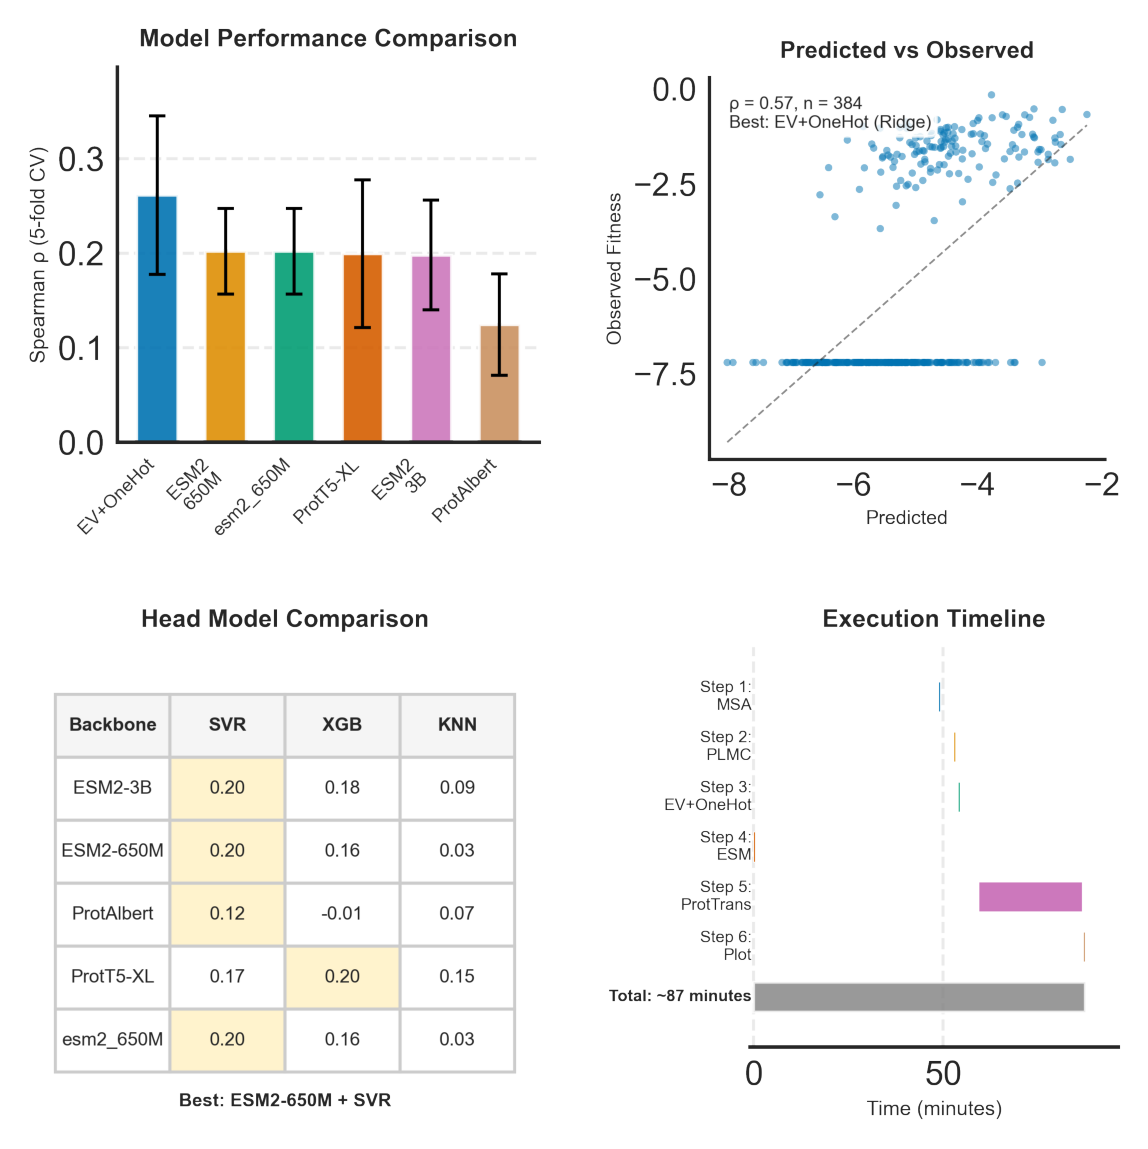


Elapsed: 4.9s


In [12]:
import os, time
import pandas as pd
_t0 = time.time()

# ---- 6.1 Collect and aggregate all model results ----
results = []

# EV+OneHot — metrics_summary.csv (stage/fold format)
ev_path = os.path.join(RESULTS_DIR, "metrics_summary.csv")
if os.path.exists(ev_path):
    ev = pd.read_csv(ev_path)
    cv_mean = ev[ev["fold"] == "mean"]["spearman_correlation"].values[0]
    cv_std  = ev[ev["fold"] == "std"]["spearman_correlation"].values[0]
    results.append({"backbone": "EV+OneHot", "head": "ridge",
                    "mean_cv_spearman": cv_mean, "std_cv_spearman": cv_std})
else:
    print(f"Warning: EV+OneHot metrics not found at {ev_path}")

# ESM & ProtTrans — training_summary.csv in subdirectories
for dir_name in sorted(os.listdir(RESULTS_DIR)):
    summary = os.path.join(RESULTS_DIR, dir_name, "training_summary.csv")
    if not os.path.exists(summary):
        continue
    df = pd.read_csv(summary)
    if "mean_cv_spearman" in df.columns:
        mean_sp = df["mean_cv_spearman"].values[0]
        std_sp  = df["std_cv_spearman"].values[0]
    elif "cv_mean" in df.columns:
        mean_sp = df["cv_mean"].values[0]
        std_sp  = df["cv_std"].values[0]
    else:
        continue
    # Skip NaN results (e.g. ProtAlbert can produce NaN with small datasets)
    if pd.isna(mean_sp):
        print(f"  Skipping {dir_name} (NaN CV results)")
        continue
    parts = dir_name.rsplit("_", 1)
    if len(parts) == 2:
        results.append({"backbone": parts[0], "head": parts[1],
                        "mean_cv_spearman": mean_sp, "std_cv_spearman": std_sp})

all_models = pd.DataFrame(results).sort_values("mean_cv_spearman", ascending=False)
all_models.to_csv(os.path.join(RESULTS_DIR, "all_models_comparison.csv"), index=False)
print(f"\nSaved {len(results)} model results to all_models_comparison.csv\n")
print(all_models.to_string(index=False))

if len(results) == 0:
    print("\n⚠️  No model results found. Check that Steps 3-5 completed successfully.")
else:
    # ---- 6.2 Generate four-panel visualization ----
    VIZ_SCRIPT = os.path.join(REPO_DIR, "workflow-skills", "scripts", "fitness_modeling_viz.py")

    # Install viz deps if needed, then run with system python
    run_cmd("pip install -q matplotlib seaborn scipy Pillow")
    run_cmd(f"python {VIZ_SCRIPT} {RESULTS_DIR}")

    # ---- 6.3 Display figure inline ----
    from IPython.display import display, Image

    summary_png = os.path.join(RESULTS_DIR, "figures", "fitness_modeling_summary.png")
    if os.path.exists(summary_png):
        print("\nFour-panel summary:")
        display(Image(filename=summary_png, width=800))
    else:
        # Try individual figures
        figs_dir = os.path.join(RESULTS_DIR, "figures")
        if os.path.isdir(figs_dir):
            for f in sorted(os.listdir(figs_dir)):
                if f.endswith(".png"):
                    print(f"\n{f}:")
                    display(Image(filename=os.path.join(figs_dir, f), width=500))
        else:
            print("No figures generated — check logs above.")

print(f"\nElapsed: {time.time() - _t0:.1f}s")

---
## Instructions & Troubleshooting

### Data Format
Your `data.csv` must contain at minimum:
- **`seq`** — Full protein sequence
- **`log_fitness`** — Log-transformed fitness value (target)

Your `wt.fasta` should contain the wild-type reference sequence in standard FASTA format.

### Common Issues

| Problem | Solution |
|---------|----------|
| `uniref100.model_params not found` | Re-run Step 2 — symlinks may not have been created |
| `wt.fasta not found` in EV+OneHot | Ensure wt.fasta is in RESULTS_DIR (Step 0) |
| ESM embeddings extraction fails | Check that `esm_mcp` Docker image is pulled (`pmcp status`) |
| GPU Out of Memory | Try smaller backbone (ESM2-650M instead of 3B) |
| Low Spearman correlation | Check data quality; ensure proper log-transformation |
| MCP not found | Run `pmcp install <mcp_name>` to pull the Docker image and register |
| Docker image not pulled | Run `pmcp install <mcp_name>` to pull the image |

### Model Performance Reference

| Model | Typical CV Spearman | Best Use |
|-------|-------------------|----------|
| EV+OneHot | 0.20–0.35 | Baseline, interpretable |
| ESM2-650M | 0.15–0.25 | Fast, good balance |
| ESM2-3B | 0.18–0.28 | Higher accuracy |
| ProtT5-XL | 0.15–0.25 | Alternative to ESM |
| ProtAlbert | 0.08–0.15 | Lightweight option |

**Recommended head models:** SVR (most stable), XGBoost (higher potential), KNN (simple baseline)

### References
- [ESM](https://github.com/facebookresearch/esm) — Meta's protein language models
- [ProtTrans](https://github.com/agemagician/ProtTrans) — Protein transformer embeddings
- [PLMC](https://github.com/debbiemarkslab/plmc) — Evolutionary coupling analysis
- [ProteinMCP](https://github.com/charlesxu90/ProteinMCP) — This project